### Motivating Example

To give a simple concrete example, lets suppose that we are given two of normal distributions $N(\mu_1,1)$ and $N(\mu_2, 1)$ where a normal distribution is defined as $f(x\ |\ \mu,\ \sigma^2)=\frac{1}{\sqrt{2\sigma^2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$. Our goal is to find a new approximating normal distribution $N(\mu_Q, \sigma_Q)$ that best fits the sum of the original normal distributions.

Here we run into a problem: **how do we define the quality of fit of the original distribution to the new distribution?** For example, would it be better to smooth out the approximating normal distribution across the two original modes or to fully cover one mode while leaving the other one uncovered? Visually, this corresponds to preferring option A or option B in the following plots:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
from scipy import stats

In [2]:
x = np.linspace(-10, 10, num=300)
norm_1 = stats.norm.pdf(x, loc=3) / 2
norm_2 = stats.norm.pdf(x, loc=-3) / 2
two_norms = norm_1 + norm_2

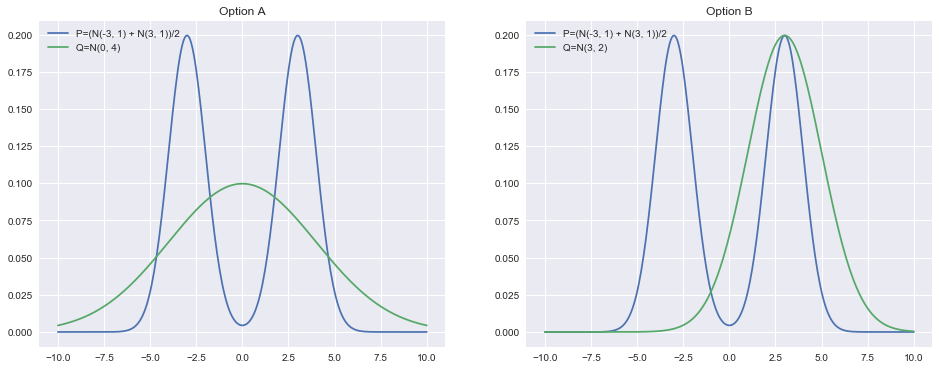

In [3]:
approx_norm_middle = stats.norm.pdf(x, loc=0, scale=4)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(x, two_norms, label='P=(N(-3, 1) + N(3, 1))/2')
plt.plot(x, approx_norm_middle, label='Q=N(0, 4)')
plt.title('Option A')
plt.legend(loc=2)

approx_norm_side = stats.norm.pdf(x, loc=3, scale=2)
plt.subplot(1, 2, 2)
plt.plot(x, two_norms, label='P=(N(-3, 1) + N(3, 1))/2')
plt.plot(x, approx_norm_side, label='Q=N(3, 2)')
plt.title(f'Option B')
plt.legend(loc=2)

plt.show()

To give one answer to this question lets first label the original distribution (average of two normals) $P$ and the distribution we are using to approximate it $Q$. The view that the KL divergence takes is of asking "if I gave someone only $Q$, how much *additional* information would they need to know everything about $P$?"

The usefulness of this formulation becomes obvious if you consider trying to approximate a very complex distribution $P$ with a simpler distribution $Q$. **You want to know how bad your new approximation $Q$ is!**. To do so we first need to visit the concepts of entropy and cross entropy though.

### Entropy

We can formalize this notion of counting the information contained in a distribution by computing its [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory). An intuitive way to understand what entropy means is by viewing it as the number of bits needed to encode some piece of information. For example, if I toss a coin three times I can have complete information of the events that occurred using only three bits (a 1 or 0 for each heads/tails).

We are interested in the entropy of probability distributions which is defined as:

$$
H(X)=-\sum_{i=1}^n P(x_i)\log P(x_i)
$$

That is all well and good, but what does it mean? Lets start with a simple concrete example. Suppose we have a simple probability distribution over the likelihood of a coin flip resulting in heads or tails $[p, 1-p]$. Plugging this into the formula for entropy $H(x)$ we get $H(X)=-(p\log p +(1-p)\log (1-p))$

Setting $p=.5$  results in $H(x)=.69$, and setting $p=.9$ results in $H(x)=.32$. We can also observe that as $p\rightarrow 1$, $H(X)\rightarrow 0$. This shows that if $p$ is very close to $1$ (where almost all the coin tosses will be heads), then the entropy is low. If $p$ is close to $.5$ then the entropy is at its peak.

Conceptually this makes sense since there is more information in a sequence of coin tosses where the results are mixed rather than one where they are all the same. You can see this by considering the case where the distribution generates heads with likelihood $.99$ and tails with likelihood $.01$. A naive way to convey this information would be to report a $1$ for each heads and a $0$ for each tails. One way to represent this more efficiently would be to encode every two heads as a $1$, one heads as $01$, and tails as $00$ (note that there is no $0$ symbol otherwise you would not be able to tell whether $01$ meant a tails then a heads or one heads). This means that for every pair of heads we can represent it in half as many bits, but what about the other cases? We only need to represent a single heads when a tails occurs for which the overall cost  of this combination is $4$ bits for 2 numbers. Take an example of encoding 99 heads and 1 tails: it would use $98/2=54$ bits to represent nearly all the heads and $4$ bits for the remaining heads and tails for a grand total of $58$ bits. This is much less than $100$ bits and its all possible because the entropy is low!

Now lets formalize the intuition from that example and return to the normal definition of entropy to explain why the entropy is defined that way.

$$
H(X)=-\sum_{i=1}^n P(x_i)\log P(x_i)=\sum_{i=1}^n P(x_i)\log \frac{1}{P(x_i)}
$$

To assist us lets define an information function $I$ in terms of an event $i$ and probability of that event $p_i$. How much information is acquired due to the observation of event $i$? Consider the properties of the information function $I$

1. When $p$ goes up then $I(p)$ goes down. When $p$ goes down then $I(p)$ goes up. This is sensible because under the coin toss example making a particular event more likely caused the entropy to go down and vice versa.
2. $I(p)\ge 0$: Information cannot be negative, also sensible.
3. $I(1)=0$: Events that always occur contain no information. This makes sense since as we took the limit of $p\rightarrow 1$, $H(X)\rightarrow 0$.
4. $I(p_1p_2)=I(p_1)+I(p_2)$: Information due to independent events is additive. 

To see why property (4) is crucial and true consider two individual events. If the first event could result in one of $n$ equally likely outcomes and the second event in $m$ equally likely outcomes then there are $mn$ possible outcomes of both events combined. From information theory we know that $\log_2(n)$ bits and $\log_2(m)$ bits are required to encode events $n$ and $m$ respectively. From the property of logarithms we know that $\log_2(n)+\log_2(m)=\log_2(mn)$ so logarithmic functions preserve (4)! If we recall that the events are equally likely with some probability $p$ then we can realize that $1/p$ is the number of possible outcomes so it corresponds to choosing $I(p)=\log(1/p)$ (this generalizes with some more math). If we sample $N$ points then we observe each outcome $i$ on average $n_i=Np_i$. Thus the total amount of information received is:

$$
\sum_i n_i I(p_i)=\sum_i N p_i\log\frac{1}{p_i}
$$

Finally note that if we want the average amount of information per event that is simply $\sum_i p_i\log\frac{1}{p_i}$ which is exactly the expression for entropy $H(X)$

### Cross Entropy

We have now seen that entropy gives us a way to quantify the information content of a given probability distribution, but what about the information content of one distribution relative to another? The [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) which is defined similarly to the regular entropy is used to calculate this. It quantifies the amount of information required to encode information coming from a probability distribution $P$ by using a different/wrong distribution $Q$. In particular, we want to know the average number of bits needed to encode some outcomes $x_i$ from $X$ with the probability distribution $q(x_i)=2^{-l_i}$ where $l_i$ is the length of the code for $x_i$ in bits. To arrive at the definition for cross entropy we will take the expectation of this length over the probability distribution $p$.

$$
\begin{align*}
H(p,q)&=E_p[l_i]=E_p\big[\log\frac{1}{q(x_i)}\big]\\
H(p,q)&=\sum_{x_i}p(x_i)\log\frac{1}{q(x_i)}\\
H(p,q)&=-\sum_x p(x)\log q(x)
\end{align*}
$$

With the definition of the cross entropy we can now move onto combining it with the entropy to arrive at the KL divergence.

### KL Divergence

Now armed with the definitions for entropy and cross entropy we are ready to return to defining the KL divergence. Recall that $H(P, Q)$ represents the amount of information needed to encode $P$ with $Q$. Also recall that $H(P)$ is the amount of information necessary to encode $P$. Knowing these makes defining the KL divergence trivial as simply the amount of information needed to encode $P$ with $Q$ minus the amount of information to encode $P$ with itself:

$$
\begin{align*}
D_{KL}(P||Q)&=H(P,Q)-H(P)\\
&=-\sum_x p(x)\log q(x)+\sum_x p(x)\log p(x)\\
&=\sum_x\bigg[p(x)[\log p(x)-\log q(x)]\bigg]\\
&=\sum_x p(x)\log\frac{p(x)}{q(x)}
\end{align*}
$$

With the origin and derivation of the KL divergence clear now, lets get some intuition on how the KL divergence behaves then returning to the original example involving two normal distributions. Observe that:

1. When $p(x)$ is large, but $q(x)$ is small, the divergence gets very big. This corresponds to not covering $P$ well with $Q$
2. When $p(x)$ is small, but $q(x)$ is large, the divergence is also large, but not as large as in (1). This corresponds to putting $Q$ where $P$ is not.

I have again plotted the normal distributions from the beginning of this post, but am now including the raw value of the KL divergence as well as its value at each point.

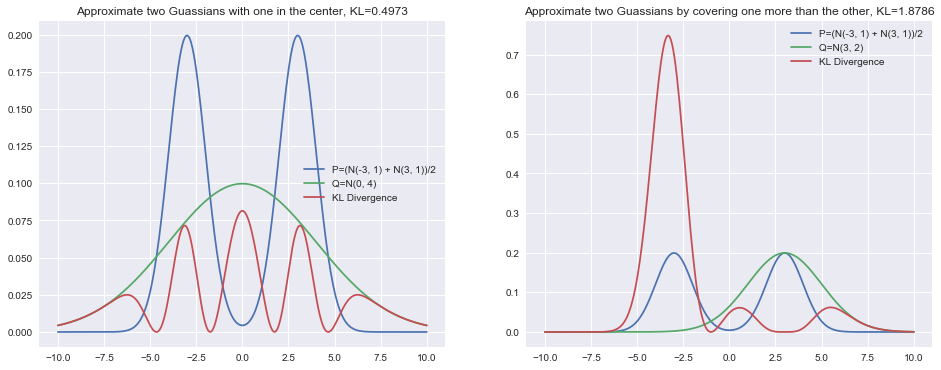

In [4]:
approx_norm_middle = stats.norm.pdf(x, loc=0, scale=4)
middle_kl = stats.entropy(two_norms, approx_norm_middle)
middle_pointwise_kl = scipy.special.kl_div(two_norms, approx_norm_middle)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(x, two_norms, label='P=(N(-3, 1) + N(3, 1))/2')
plt.plot(x, approx_norm_middle, label='Q=N(0, 4)')
plt.plot(x, middle_pointwise_kl, label='KL Divergence', linestyle='-')
plt.title(f'Approximate two Guassians with one in the center, KL={middle_kl:.4f}')
plt.legend()

plt.subplot(1, 2, 2)
approx_norm_side = stats.norm.pdf(x, loc=3, scale=2)
side_kl = stats.entropy(two_norms, approx_norm_side)
side_pointwise_kl = scipy.special.kl_div(two_norms, approx_norm_side)
plt.plot(x, two_norms, label='P=(N(-3, 1) + N(3, 1))/2')
plt.plot(x, approx_norm_side, label='Q=N(3, 2)')
plt.plot(x, side_pointwise_kl, label='KL Divergence', linestyle='-')
plt.title(f'Approximate two Guassians by covering one more than the other, KL={side_kl:.4f}')
plt.legend()
plt.show()

By looking at this its now easy to see how properties (1) and (2) play out in practice. The KL divergence is much happier with the solution on the left since $P$ is always at least partially covered. It is comparatively unhappy with the right solution since it leaves the left normal mode uncovered. Thus, in general the KL divergence of $P$ approximated with $Q$ prefers to average out modes.

One increasingly common use case for the KL divergence in machine learning is in [Variational Inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods). For a number of reasons, the optimized quantity is the KL divergence of $Q$ approximated by $P$ written as $D_{KL}(Q||P)$. The KL divergence is **not** symmetric so the behavior could be and in general is different. I have drawn the same normal distributions but instead this time using this alternative use of the KL divergence.

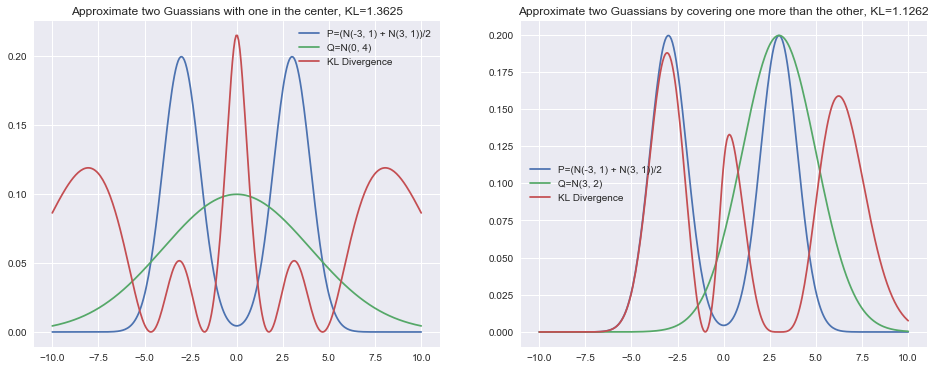

In [5]:
approx_norm_middle = stats.norm.pdf(x, loc=0, scale=4)
middle_kl = stats.entropy(approx_norm_middle, two_norms)
middle_pointwise_kl = scipy.special.kl_div(approx_norm_middle, two_norms)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(x, two_norms, label='P=(N(-3, 1) + N(3, 1))/2')
plt.plot(x, approx_norm_middle, label='Q=N(0, 4)')
plt.plot(x, middle_pointwise_kl, label='KL Divergence', linestyle='-')
plt.title(f'Approximate two Guassians with one in the center, KL={middle_kl:.4f}')
plt.legend()

plt.subplot(1, 2, 2)
approx_norm_side = stats.norm.pdf(x, loc=3, scale=2)
side_kl = stats.entropy(approx_norm_side, two_norms)
side_pointwise_kl = scipy.special.kl_div(approx_norm_side, two_norms)
plt.plot(x, two_norms, label='P=(N(-3, 1) + N(3, 1))/2')
plt.plot(x, approx_norm_side, label='Q=N(3, 2)')
plt.plot(x, side_pointwise_kl, label='KL Divergence', linestyle='-')
plt.title(f'Approximate two Guassians by covering one more than the other, KL={side_kl:.4f}')
plt.legend()
plt.show()

The behavior of the KL divergence here is quite different. It will specifically punish when there is mass in $Q$, but not in $P$. This can be seen in the center of the left plot. It will also not punish as heavily when there is mass in $P$, but not in $Q$ as seen in the right plot. The left normal distribution's KL divergence is comparatively much smaller than before.

There are many uses for the KL divergence so I hope that this post was enlightening in building up the concept from the ground up!